**Библиотеки**

In [1]:
import numpy as np
from os import walk
from PIL import Image, ImageFilter, ImageOps

**Загрузка и преобразование оригинальных файлов**

In [2]:
img_dir = 'train/'
_, _, indoor = next(walk(img_dir + 'indoor'))
_, _, outdoor = next(walk(img_dir + 'outdoor'))

indoor = [img_dir + 'indoor/' + filename for filename in indoor]
outdoor = [img_dir + 'outdoor/' + filename for filename in outdoor]

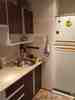

In [106]:
img = Image.open(indoor[-1])
img

Формирование признаков:

In [108]:
X = np.array([]).reshape(0, 16)
for img_path in indoor + outdoor:
    img = Image.open(img_path)
    array_img = np.asarray(img)
    l = array_img.shape[0]
    # X:
    rmean = array_img[:, :, 0].mean()  # x1
    gmean = array_img[:, :, 1].mean()  # x2
    bmean = array_img[:, :, 2].mean()  # x3
    rstd = array_img[:, :, 0].std()  # x4
    gstd = array_img[:, :, 1].std()  # x5
    bstd = array_img[:, :, 2].std()  # x6
    rq25 = np.quantile(array_img[:, :, 0], 0.25)  # x7
    gq25 = np.quantile(array_img[:, :, 1], 0.25)  # x8
    bq25 = np.quantile(array_img[:, :, 2], 0.25)  # x9
    rmed = np.median(array_img[:, :, 0])  # x10
    gmed = np.median(array_img[:, :, 1])  # x11
    bmed = np.median(array_img[:, :, 2])  # x12
    rq75 = np.quantile(array_img[:, :, 0], 0.75)  # x13
    gq75 = np.quantile(array_img[:, :, 1], 0.75)  # x14
    bq75 = np.quantile(array_img[:, :, 2], 0.75)  # x15
    
    intens = array_img.sum(axis=2)
    mid = intens[:l//2, :].mean() - intens[l//2:, :].mean()  # x16
    
    x = np.array([rmean, gmean, rstd, rstd, gstd, bstd, rq25, gq25, bq25,
                  rmed, gmed, bmed, rq75, gq75, bq75, mid])
    X = np.vstack([X, x])

In [109]:
X.shape

(55322, 16)

Формирование целевых признаков:

In [110]:
y = np.array([0 for _ in indoor] + [1 for _ in outdoor])

Подготовка данных:

In [111]:
from sklearn.preprocessing import StandardScaler

In [123]:
scaled_X = StandardScaler().fit_transform(X)
print(scaled_X.mean(), scaled_X.std())

-1.2327525372810865e-15 0.9999999999999986


In [113]:
from sklearn.model_selection import train_test_split

In [114]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.01,
                                                    random_state=42)

**Модель и обучение**

In [115]:
from sklearn.linear_model import LogisticRegression

In [116]:
model = LogisticRegression()

In [117]:
model.fit(X_train, y_train)

C:\Users\ski6a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

**Проверка качетсва**

In [118]:
from sklearn.metrics import confusion_matrix

In [119]:
pred = model.predict(X_test)

In [120]:
cm = confusion_matrix(y_test, pred)
cm

array([[242,  45],
       [ 60, 207]], dtype=int64)

$F-мера$:

In [121]:
def F_score(m):
    d = m.diagonal()
    f1 = 2 * d/m.sum(axis=1) * d/m.sum(axis=0) / (d/m.sum(axis=1) + d/m.sum(axis=0))
    # f1, F-мера, F-взешн. многокласс.
    return f1, f1.mean(), m.sum(axis=0)@f1 / m.sum()

In [122]:
f1, F, Fm = F_score(cm)
print('f1:', f1)
print('F:', F)
print('Fвз.мн.:', Fm)

f1: [0.82173175 0.79768786]
F: 0.8097098049991658
Fвз.мн.: 0.8107948179709609
